In [226]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, time, timedelta
import ast
import numpy as np

## 1. Introduction & Dataset Overview  

ACCRE staff have hypothesized that the job scheduler sometimes becomes unresponsive because it is processing large bursts of job completions. This especially affects automated job submitters, such as members of the Open Science Grid.

This project is meant to evaluate whether the data supports the hypothesis of bursts of job completions contributing to scheduler unresponsiveness.

This project makes use of three datasets:  
* fullsample.csv: Contains slurm job records. Job completions correspond to jobs in the "COMPLETED" state with exit code "0:0".  
* slurm_wrapper_ce5.log, slurm_wrapper_ce6.log: These log files contain every slurm command executed by the CE5 and CE6 servers (gateways to the Open Science Grid).  
Unresponsive periods are indicated by "sbatch" commands from user 9204 that have:  
    * return code = 1
    * execution time > 15 seconds

## 2. Data Exploration & Cleaning  

### Full sample data (Slurm job records)

The fullsample dataset contains job records, with one row per job. Each job gets a unique ID, contained in the JOBID column.

Some jobs can be submitted as arrays of similar jobs. These are listed with an underscore in the JOBID, where the number after the underscore indicates the tasknumber.

We have data for 7,395,885 total jobs (or job parts).

##### Code:

In [2]:
jobs = pd.read_csv("../data/fullsample.csv")
jobs.head(5)

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0
1,30853133,COMPLETED,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06T19:04:39,2021-09-05T19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09T16:52:51,2021-09-07T20:52:55,65536Mn,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17T07:45:07,2021-09-10T16:45:24,16384Mn,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0


In [5]:
jobs.shape[0]

7395885

##### The full sample dataset contains the following columns: 

| Column | Description |
|---|---|
| **JOBID** | The identification number of the job or job step. Array jobs are in the form ArrayJobID_ArrayTaskID.  | 
| **STATE** | Job state or status (COMPLETED, CANCELLED, FAILED, TIMEOUT, PREEMPTED, etc.). | 
| **BEGIN** | Beginning time for the job (may be different from the submit time). |
| **END** | Ending time for the job.     |
| **REQMEM** | Requested memory in megabytes. May be per-core (Mc) or per-node (Mn).   |
| **USEDMEM** | Used memory in megabytes per-node.   |
| **REQTIME** | Requested time in d-hh:mm:ss or hh:mm:ss.   |
| **USEDTIME** | Used time in d-hh:mm:ss or hh:mm:ss.   |
| **NODES** | Number of servers used for this job.   |
| **CPUS** | Total number of CPU-cores allocated to the job.   |
| **PARTITION** | Identifies the partition on which the job ran.    |
| **EXITCODE** | The exit code returned by the job script or salloc, typically as set by the exit() function. Following the colon is the signal that caused the process to terminate if it was terminated by a signal.    |

##### Code:

In [4]:
jobs.columns

Index(['JOBID', 'STATE', 'BEGIN', 'END', 'REQMEM', 'USEDMEM', 'REQTIME',
       'USEDTIME', 'NODES', 'CPUS', 'PARTITION', 'EXITCODE'],
      dtype='object')

##### We see that each row in the dataset contains a unique job (or job part).

##### Code:

In [5]:
(jobs['JOBID'].value_counts()>1).sum()

np.int64(0)

##### Most jobs ran on 1, 2, 3, or 8 nodes. There are a few outlier jobs that ran on 200 and 500 nodes.

##### Code:

In [6]:
jobs['NODES'].value_counts().reset_index().sort_values(by='NODES')

,NODES,count
0,1,7385963
1,2,3525
2,3,2716
4,4,860
6,5,217
...,...,...
64,138,1
69,150,1
68,180,1
47,200,2


##### Most jobs ran on the "production", "nogpfs", or "pascal" partitions. The "debug" and "sam" partitions are test jobs that are expected to be short, and the "maxwell", "pascal", and "turing" partitions are for GPU resources.

##### Code:

In [7]:
jobs['PARTITION'].value_counts()

PARTITION
production              7019578
nogpfs                   147229
pascal                   124453
sam                       64967
turing                    21424
maxwell                   11278
cgw-maizie                 4309
debug                      1616
cgw-platypus                379
cgw-dsi-gw                  228
cgw-capra1                  157
cgw-dougherty1              125
cgw-horus                    61
cgw-cqs1                     28
cgw-hanuman                  21
cgw-sideshowbob              14
cgw-vm-qa-flatearth1          9
cgw-tbi01                     8
cgw-rocksteady                1
Name: count, dtype: int64

##### Most jobs are in the 'COMPLETED' state, with an exit code of 0:0. The next most common states are 'CANCELLED' and 'FAILED'. Also note that there are 208 running jobs and 443 pending jobs.

We also see many states of the form 'CANCELLED by \<number\>', where '\<number\>' might refer to a user ID.

##### Code:

In [101]:
jobs.groupby(['STATE','EXITCODE'])['JOBID'].count()

STATE          EXITCODE
CANCELLED      0:0         5378
               0:11          35
               0:15        1886
               0:40           1
               0:6           18
                           ... 
FAILED         9:0            3
NODE_FAIL      1:0            2
OUT_OF_MEMORY  0:125       1739
PENDING        0:0          443
RUNNING        0:0          208
Name: JOBID, Length: 227, dtype: int64

##### Note that all 'RUNNING' jobs have an 'END' of 'Unknown'.

##### Code:

In [9]:
jobs[jobs['STATE']=='RUNNING'].head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0
7343,31874232_1949,RUNNING,2021-08-31T23:55:05,Unknown,2048Mn,0,00:15:00,36-20:34:17,1,1,production,0:0
7650,31874232_2461,RUNNING,2021-08-31T23:58:07,Unknown,2048Mn,144.11M,00:15:00,36-20:31:15,1,1,production,0:0
7676,31874232_2487,RUNNING,2021-08-31T23:58:07,Unknown,2048Mn,0,00:15:00,36-20:31:15,1,1,production,0:0
8621,31874232_3432,RUNNING,2021-09-01T00:03:07,Unknown,2048Mn,0,00:15:00,36-20:26:15,1,1,production,0:0


In [10]:
jobs[jobs['STATE']=='RUNNING']['END'].nunique()

1

##### Note that all 'PENDING' jobs have both a 'BEGIN' and an 'END' of 'Unknown' and a 'USEDTIME' of 00:00:00.

##### Code:

In [11]:
jobs[jobs['STATE']=='PENDING'].head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
830993,31940830,PENDING,Unknown,Unknown,251904Mn,0,13-18:00:00,00:00:00,1,16,production,0:0
923853,32808176,PENDING,Unknown,Unknown,81920Mn,0,3-00:00:00,00:00:00,1,2,production,0:0
923922,32907807_430,PENDING,Unknown,Unknown,16384Mn,0,2-02:00:00,00:00:00,1,1,production,0:0
923923,32907807_311,PENDING,Unknown,Unknown,16384Mn,0,2-02:00:00,00:00:00,1,1,production,0:0
923924,32907807_325,PENDING,Unknown,Unknown,16384Mn,0,2-02:00:00,00:00:00,1,1,production,0:0


In [12]:
jobs[jobs['STATE']=='PENDING'][['BEGIN','END','USEDTIME']].nunique()

BEGIN       1
END         1
USEDTIME    1
dtype: int64

##### Furthermore, we see that any job with 'Unknown' as the 'BEGIN' or 'END' is in either a 'PENDING' or 'RUNNING' state.

##### Code:

In [13]:
jobs[(jobs['BEGIN'] == 'Unknown') | (jobs['END'] == 'Unknown')].value_counts('STATE')

STATE
PENDING    443
RUNNING    208
Name: count, dtype: int64

##### We see that some jobs have small discrepancies in the USEDTIME when compared to the value of the end time minus the begin time. Other jobs even have an end time that is before the begin time. 

##### Code:

In [36]:
# Check data integrity for the 'USEDTIME' column. It should equal 'END' minus 'BEGIN'

# Create a new dataframe with just the begin, end, and usedtime times for jobs that have a begin and end time
job_times = jobs[(jobs['BEGIN'] != 'Unknown') & (jobs['END'] != 'Unknown')][['JOBID','BEGIN','END','USEDTIME']]

# Convert 'END' and 'BEGIN' to datetime
job_times['BEGIN'] = pd.to_datetime(job_times['BEGIN'], format = "%Y-%m-%dT%H:%M:%S")
job_times['END'] = pd.to_datetime(job_times['END'], format = "%Y-%m-%dT%H:%M:%S")

# Manually calculate time difference between 'BEGIN' and 'END' for each row and assign to a new 'USEDTIME_MANUAL' column
# Clean up the output by replacing ' days ' with a dash, and remove leading '0-' if it is present
usedtime_manual = [(str(diff)).replace(' days ', '-') for diff in (job_times['END'] - job_times['BEGIN'])]
usedtime_manual_cleaned = [value.replace('0-','') if value[:2]=='0-' else value for value in usedtime_manual]
job_times['USEDTIME_MANUAL'] = usedtime_manual_cleaned

# Find instances where the manually calculated usedtime matches the value of 'USEDTIME
usedtime_equ = job_times['USEDTIME_MANUAL'] == job_times['USEDTIME']

# Find any rows with inconsistent 'USEDTIME' values and filter them out of the data 
inconsistent_usedtime = job_times[~usedtime_equ]
inconsistent_usedtime

,JOBID,BEGIN,END,USEDTIME,USEDTIME_MANUAL
4186164,27050750_43,2021-03-06 19:39:30,2021-03-16 20:39:41,10-00:00:11,10-01:00:11
4186165,27050750_44,2021-03-07 18:54:30,2021-03-17 19:55:04,10-00:00:34,10-01:00:34
4186166,27050750_45,2021-03-07 18:54:30,2021-03-17 19:55:04,10-00:00:34,10-01:00:34
4186170,27050750_49,2021-03-10 01:45:37,2021-03-20 02:46:01,10-00:00:24,10-01:00:24
4186171,27050750_50,2021-03-11 07:42:19,2021-03-20 10:04:20,9-01:22:01,9-02:22:01
...,...,...,...,...,...
6257214,25494314,2020-11-01 01:38:54,2020-11-01 01:17:42,00:38:48,-1-+23:38:48
6257215,25494322,2020-11-01 01:37:07,2020-11-01 01:02:01,00:24:54,-1-+23:24:54
6257230,25494499,2020-11-01 01:49:02,2020-11-01 01:35:37,00:46:35,-1-+23:46:35
6257231,25494500,2020-11-01 01:49:02,2020-11-03 00:13:30,1-23:24:28,1-22:24:28


Example of a job that has a discrepancy in the USEDTIME when compared to the value of the end time minus the begin time:

In [42]:
inconsistent_usedtime[inconsistent_usedtime['JOBID']=='27050750_43'][['JOBID','USEDTIME','USEDTIME_MANUAL']]

,JOBID,USEDTIME,USEDTIME_MANUAL
4186164,27050750_43,10-00:00:11,10-01:00:11


Example of a job that has an end time that is before the begin time:

In [43]:
inconsistent_usedtime[inconsistent_usedtime['JOBID']=='25494314'][['JOBID','BEGIN','END']]

,JOBID,BEGIN,END
6257214,25494314,2020-11-01 01:38:54,2020-11-01 01:17:42


##### We see that the full sample data does not contain any missing values

##### Code:

In [9]:
nan_count_per_column = jobs.isnull().sum()
nan_count_per_column

JOBID        0
STATE        0
BEGIN        0
END          0
REQMEM       0
USEDMEM      0
REQTIME      0
USEDTIME     0
NODES        0
CPUS         0
PARTITION    0
EXITCODE     0
dtype: int64

### OSG Job Logs from CE5/CE6

##### The OSG job log datasets contain logs of ACCRE jobs submitted from the Open Science Grid (specifically, from servers CE5 and CE6). We will combine these 2 datasets and then explore the data further.

##### Code:

In [191]:
ce5 = pd.read_csv("../data/slurm_wrapper_ce5.log",
                  header=None,
                  delimiter=' - ',
                  engine='python')

ce6 = pd.read_csv("../data/slurm_wrapper_ce5.log",
                  header=None,
                  delimiter=' - ',
                  engine='python')

ce5['Server']='ce5'
ce6['Server']='ce6'

In [192]:
osg_logs = pd.concat([ce5, ce6])

##### We have data for 9,541,786 total commands sent from CE5 or CE6. For each command, we have values for date, user, retry, time (i.e. time the command took to reach the ACCRE server), and return code.

##### Code:

In [193]:
# Editing column names and values for readability
osg_logs = osg_logs.rename(columns={0:'Date', 1:'User', 2:'Retry', 3:'Time', 4:'Return_Code', 5:'Command'})
osg_logs['User'] = osg_logs['User'].str.replace('user ', '')
osg_logs['Retry'] = osg_logs['Retry'].str.replace('retry ', '')
osg_logs['Time'] = osg_logs['Time'].str.replace('time ', '')
osg_logs['Return_Code'] = osg_logs['Return_Code'].str.replace('returncode ', '')

osg_logs['Command'] = list(osg_logs['Command'].str.replace('command ', ''))
# Convert command column to list type
osg_logs['Command'] = osg_logs['Command'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)

osg_logs['Leading_Command'] = osg_logs['Command'].apply(lambda x: x[0])

# Converting time and date values to the appropriate datatype
osg_logs['Time'] = osg_logs['Time'].astype(float)
osg_logs['Date'] = pd.to_datetime(osg_logs['Date'], format='ISO8601')

osg_logs.head()

,Date,User,Retry,Time,Return_Code,Command,Server,Leading_Command
0,2020-10-16 08:15:39.278699,0,0,0.073476,0,"[/usr/bin/sacct, -u, appelte1, -S, 2020-10-10]",ce5,/usr/bin/sacct
1,2020-10-16 08:18:08.313309,0,0,0.183632,0,"[/usr/bin/sacct, -u, appelte1, -S, 2020-10-10]",ce5,/usr/bin/sacct
2,2020-10-16 08:22:48.128689,0,0,0.075471,0,"[/usr/bin/sacct, -u, appelte1, -S, 2020-10-10]",ce5,/usr/bin/sacct
3,2020-10-16 08:25:13.257408,0,0,0.094844,0,"[/usr/bin/sacct, -u, appelte1, -S, 2020-10-10]",ce5,/usr/bin/sacct
4,2020-10-16 08:31:01.460723,0,0,0.074988,0,"[/usr/bin/sacct, -u, appelte1, -S, 2020-10-14]",ce5,/usr/bin/sacct


In [58]:
osg_logs.shape

(9541786, 6)

In [59]:
osg_logs.columns

Index(['Date', 'User', 'Retry', 'Time', 'Return_Code', 'Command'], dtype='object')

##### We see that the CE5/CE6 logs do not contain any missing values

##### Code:

In [15]:
nan_count_per_column = osg_logs.isnull().sum()
nan_count_per_column

0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

##### About 85% of the commands sent from CE5/6 to the scheduler went through successfully (i.e. the return code was 0). The remaining commands did not go through successfully, indicating the scheduler might have been unresponsive at that time.

##### Code:

In [47]:
osg_logs['Return_Code'].value_counts(normalize=True)

Return_Code
0      0.849578
1      0.146234
140    0.002879
255    0.001308
8      0.000001
Name: proportion, dtype: float64

##### About 13% of the commands sent from CE5/6 to the scheduler took more than 15 seconds, meaning the scheduler might have been unresponsive at that time.

##### Code:

In [60]:
(osg_logs['Time']>15).mean()

np.float64(0.1306260693752721)

##### About 19% of the commands sent from CE5/6 to the scheduler used /usr/bin/sbatch, which is our command of interest for when the scheduler becomes unresponsive.

##### Code:

In [98]:
osg_logs['Leading_Command'].value_counts(normalize=True)

Leading_Command
/usr/bin/scontrol    0.589673
/usr/bin/sbatch      0.190852
/usr/bin/scancel     0.089881
/usr/bin/sacct       0.074910
/usr/bin/squeue      0.054684
Name: proportion, dtype: float64

There is a lot of variation in the frequency of the test user sending sbatch commands to the scheduler, but most of the time deltas fall between 0 and 20 minutes. 

##### Code:

In [207]:
# Extracting just the events where the test user (user 9204) sent an sbatch command (i.e. the command starts with '/usr/bin/sbatch') to the scheduler
osg_test_sbatch = osg_logs[(osg_logs['Leading_Command']=='/usr/bin/sbatch')
        & (osg_logs['User']=='9204')].sort_values(by='Date')

# Adding a 'Time_Diff' column that shows the number of minutes since the test user sent the most recent sbatch command  
osg_test_sbatch['Time_Diff'] = osg_test_sbatch['Date'].diff() / pd.Timedelta(minutes=1)

osg_test_sbatch.head()

,Date,User,Retry,Time,Return_Code,Command,Server,Leading_Command,Time_Diff
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce5,/usr/bin/sbatch,NaN
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce6,/usr/bin/sbatch,0.000000
478,2020-10-16 08:53:15.711346,9204,0,0.142444,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce5,/usr/bin/sbatch,18.548860
478,2020-10-16 08:53:15.711346,9204,0,0.142444,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce6,/usr/bin/sbatch,0.000000
670,2020-10-16 09:04:56.472464,9204,0,0.066345,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce5,/usr/bin/sbatch,11.679352


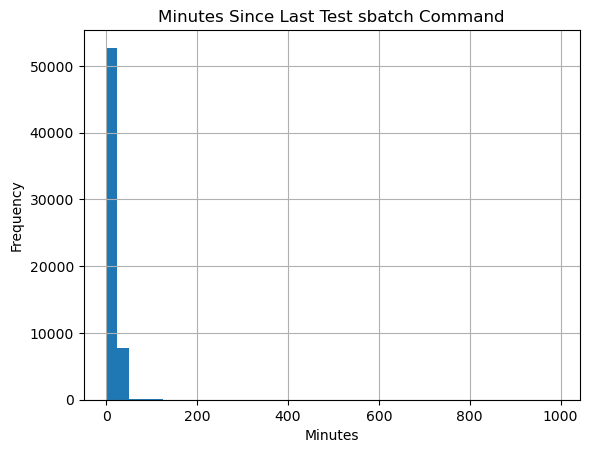

In [208]:
osg_test_sbatch['Time_Diff'].hist(bins=40)
plt.title("Minutes Since Last Test sbatch Command")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.show()

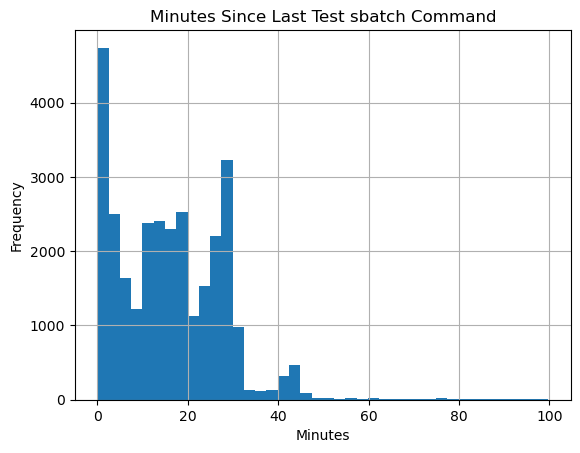

In [209]:
# Excluding outliers and zeros
osg_test_sbatch[(osg_test_sbatch['Time_Diff']<100)&(osg_test_sbatch['Time_Diff']>0)]['Time_Diff'].hist(bins=40)
plt.title("Minutes Since Last Test sbatch Command")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.show()

## 3. Feature Engineering

##### We'll convert the date and time columns to a datetime data type in both fullsample.csv and the CE5/6 slurm logs.

##### Code:

In [284]:
jobs['BEGIN'] = pd.to_datetime(jobs['BEGIN'], format = '%Y-%m-%dT%H:%M:%S', errors='coerce')
jobs['END'] = pd.to_datetime(jobs['END'], format = '%Y-%m-%dT%H:%M:%S', errors='coerce')
osg_logs['Date'] = pd.to_datetime(osg_logs['Date'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

##### Next, we'll filter out all jobs in fullsample.csv that have inconsistent 'USEDTIME' values (e.g. the begin time is after the end time, or the USEDTIME value does not equal the end time minus the begin time).

##### Code:

In [16]:
jobs = jobs[~jobs['JOBID'].isin(inconsistent_usedtime['JOBID'].to_list())]

##### Next we will extract just the job completions from fullsample.csv. These are the jobs that show a "COMPLETED" status with an exit code of 0:0.

##### Code:

In [210]:
job_completions = jobs[
        (jobs['STATE']=='COMPLETED') 
        & (jobs['EXITCODE']=='0:0')]

##### Now we'll parse CE5 and CE6 logs to narrow down to just the events where the test user (user 9204) sent an sbatch command (i.e. the command starts with '/usr/bin/sbatch') to the scheduler. 

In [300]:
osg_test_sbatch = osg_logs[(osg_logs['Leading_Command']=='/usr/bin/sbatch')
        & (osg_logs['User']=='9204')].sort_values(by='Date')

osg_test_sbatch.head(2)

,Date,User,Retry,Time,Return_Code,Command,Server,Leading_Command
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce5,/usr/bin/sbatch
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce6,/usr/bin/sbatch


##### We can now add an indicator column that reflects whether the scheduler was responsive (i.e. the returncode is zero and the time is less than 15) or unresponsive (i.e. the returncode is non-zero and the itme is greater than 15). 

In [301]:
osg_test_sbatch['Responsive'] = [1 if (item[0]<=15 and item[1]=='0') else 0 for item in zip(osg_test_sbatch['Time'],osg_test_sbatch['Return_Code'])]

In [302]:
osg_test_sbatch.head(2)

,Date,User,Retry,Time,Return_Code,Command,Server,Leading_Command,Responsive
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce5,/usr/bin/sbatch,1
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce6,/usr/bin/sbatch,1


##### Next we will create time windows for further analysis. For each sbatch command sent by the test user to the scheduler, we will look at the preceding 5 minutes, 15 minutes, 30 minutes, and 1 hour.

In [304]:
osg_test_sbatch['Past_5_Min'] = osg_test_sbatch['Date'].apply(lambda x: (x - timedelta(minutes=5), x)).values
osg_test_sbatch['Past_15_Min'] = osg_test_sbatch['Date'].apply(lambda x: (x - timedelta(minutes=15), x)).values
osg_test_sbatch['Past_30_Min'] = osg_test_sbatch['Date'].apply(lambda x: (x - timedelta(minutes=30), x)).values
osg_test_sbatch['Past_1_Hour'] = osg_test_sbatch['Date'].apply(lambda x: (x - timedelta(hours=1), x)).values
osg_test_sbatch.head(2)

,Date,User,Retry,Time,Return_Code,Command,Server,Leading_Command,Responsive,Past_15_Min,Past_5_Min,Past_30_Min,Past_1_Hour
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce5,/usr/bin/sbatch,1,"(2020-10-16 08:19:42.779719, 2020-10-16 08:34:...","(2020-10-16 08:29:42.779719, 2020-10-16 08:34:...","(2020-10-16 08:04:42.779719, 2020-10-16 08:34:...","(2020-10-16 07:34:42.779719, 2020-10-16 08:34:..."
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce6,/usr/bin/sbatch,1,"(2020-10-16 08:19:42.779719, 2020-10-16 08:34:...","(2020-10-16 08:29:42.779719, 2020-10-16 08:34:...","(2020-10-16 08:04:42.779719, 2020-10-16 08:34:...","(2020-10-16 07:34:42.779719, 2020-10-16 08:34:..."


##### We will now calculate the total number of ACCRE jobs that completed during the chosen time windows.

In [305]:
_5_min_windows = pd.IntervalIndex.from_tuples(osg_test_sbatch['Past_5_Min'], closed='left')

# Get the index (or indices) of the interval(s) in time_windows that each completed job's end time falls into
job_indices = _5_min_windows.get_indexer_non_unique(job_completions['END'])

# If a completed job's end time does not fall into any interval, it returns -1; we will filter these out
valid_indices = [int(index) for index in job_indices[0] if index != -1]

# Count total number of completed jobs' end times that fall within each time window 
completed_jobs_counts = np.bincount(valid_indices, minlength=len(_5_min_windows))

osg_test_sbatch['Completed_Jobs_5_Min'] = completed_jobs_counts

In [306]:
_15_min_windows = pd.IntervalIndex.from_tuples(osg_test_sbatch['Past_15_Min'], closed='left')

# Get the index (or indices) of the interval(s) in time_windows that each completed job's end time falls into
job_indices = _15_min_windows.get_indexer_non_unique(job_completions['END'])

# If a completed job's end time does not fall into any interval, it returns -1; we will filter these out
valid_indices = [int(index) for index in job_indices[0] if index != -1]

# Count total number of completed jobs' end times that fall within each time window 
completed_jobs_counts = np.bincount(valid_indices, minlength=len(_15_min_windows))

osg_test_sbatch['Completed_Jobs_15_Min'] = completed_jobs_counts

In [307]:
_30_min_windows = pd.IntervalIndex.from_tuples(osg_test_sbatch['Past_30_Min'], closed='left')

# Get the index (or indices) of the interval(s) in time_windows that each completed job's end time falls into
job_indices = _30_min_windows.get_indexer_non_unique(job_completions['END'])

# If a completed job's end time does not fall into any interval, it returns -1; we will filter these out
valid_indices = [int(index) for index in job_indices[0] if index != -1]

# Count total number of completed jobs' end times that fall within each time window 
completed_jobs_counts = np.bincount(valid_indices, minlength=len(_30_min_windows))

osg_test_sbatch['Completed_Jobs_30_Min'] = completed_jobs_counts

In [308]:
_1_hr_windows = pd.IntervalIndex.from_tuples(osg_test_sbatch['Past_1_Hour'], closed='left')

# Get the index (or indices) of the interval(s) in time_windows that each completed job's end time falls into
job_indices = _1_hr_windows.get_indexer_non_unique(job_completions['END'])

# If a completed job's end time does not fall into any interval, it returns -1; we will filter these out
valid_indices = [int(index) for index in job_indices[0] if index != -1]

# Count total number of completed jobs' end times that fall within each time window 
completed_jobs_counts = np.bincount(valid_indices, minlength=len(_1_hr_windows))

osg_test_sbatch['Completed_Jobs_1_Hr'] = completed_jobs_counts

In [309]:
osg_test_sbatch.head(5)

,Date,User,Retry,Time,Return_Code,Command,Server,Leading_Command,Responsive,Past_15_Min,Past_5_Min,Past_30_Min,Past_1_Hour,Completed_Jobs_5_Min,Completed_Jobs_15_Min,Completed_Jobs_30_Min,Completed_Jobs_1_Hr
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce5,/usr/bin/sbatch,1,"(2020-10-16 08:19:42.779719, 2020-10-16 08:34:...","(2020-10-16 08:29:42.779719, 2020-10-16 08:34:...","(2020-10-16 08:04:42.779719, 2020-10-16 08:34:...","(2020-10-16 07:34:42.779719, 2020-10-16 08:34:...",41,105,157,581
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce6,/usr/bin/sbatch,1,"(2020-10-16 08:19:42.779719, 2020-10-16 08:34:...","(2020-10-16 08:29:42.779719, 2020-10-16 08:34:...","(2020-10-16 08:04:42.779719, 2020-10-16 08:34:...","(2020-10-16 07:34:42.779719, 2020-10-16 08:34:...",41,105,157,581
478,2020-10-16 08:53:15.711346,9204,0,0.142444,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce5,/usr/bin/sbatch,1,"(2020-10-16 08:38:15.711346, 2020-10-16 08:53:...","(2020-10-16 08:48:15.711346, 2020-10-16 08:53:...","(2020-10-16 08:23:15.711346, 2020-10-16 08:53:...","(2020-10-16 07:53:15.711346, 2020-10-16 08:53:...",70,181,306,436
478,2020-10-16 08:53:15.711346,9204,0,0.142444,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce6,/usr/bin/sbatch,1,"(2020-10-16 08:38:15.711346, 2020-10-16 08:53:...","(2020-10-16 08:48:15.711346, 2020-10-16 08:53:...","(2020-10-16 08:23:15.711346, 2020-10-16 08:53:...","(2020-10-16 07:53:15.711346, 2020-10-16 08:53:...",70,181,306,436
670,2020-10-16 09:04:56.472464,9204,0,0.066345,0,"[/usr/bin/sbatch, /tmp/condor_g_scratch.0x5590...",ce5,/usr/bin/sbatch,1,"(2020-10-16 08:49:56.472464, 2020-10-16 09:04:...","(2020-10-16 08:59:56.472464, 2020-10-16 09:04:...","(2020-10-16 08:34:56.472464, 2020-10-16 09:04:...","(2020-10-16 08:04:56.472464, 2020-10-16 09:04:...",35,161,332,489


##### Next we will add additional features for analysis. For each sbatch command sent by the test user, we will calculate the following:  

* Number of currently running jobs at that time
* Current resource usage at that time
* Time of day (morning/afternoon/night) 
* Day of week

In [298]:
osg_test_sbatch['Weekday'] = osg_test_sbatch['Date'].dt.day_name()

## 4. Analysis & Visualizations  

## 5. Interpretation & Conclusion